# Lehnert Control

Experiment: `/network/tmp1/chenant/ant/sr_trace/2021-02-13/17-09-06`
- Lambda SF Q learning
- Starting and goal location _both_ shift by 1 square every 400 episodes
- Reset `Wr` every 400 episodes
- `sf_lr=0.0001`, all other `lr=0.1`

Today: February 13, 2021

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import files

In [5]:
sfAg_in_path = '/Users/anthony/Playground/tensorboard_logs/sr_return/2021-02-13/17-09-06/progress.csv'

pd_df_sep = '\|\|'

In [6]:
# LSF value function agent
sf_ag_raw_df = pd.read_csv(sfAg_in_path, sep=pd_df_sep)

/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [7]:
withDate_Data_df = sf_ag_raw_df.copy(deep=True)
print(len(withDate_Data_df))
withDate_Data_df[0:3]

100000


,"2021-02-13 17:09:06,794",num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,sf_lr,reward_lr,...,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg,et_loss_avg
0,"2021-02-13 17:09:06,970",4000,LehnertGridWorldEnv,"{'width': 10, 'slip_prob': 0.05, 'episode_max_...",LambdaSFQAgent,3,0.9,0.1,0.0001,0.1,...,201,0.0,None,None,None,None,3.111588e-12,1.233153e-13,0.0,None
1,"2021-02-13 17:09:07,067",4000,LehnertGridWorldEnv,"{'width': 10, 'slip_prob': 0.05, 'episode_max_...",LambdaSFQAgent,3,0.9,0.1,0.0001,0.1,...,201,0.0,None,None,None,None,4.027667e-12,8.681675e-14,0.0,None
2,"2021-02-13 17:09:07,163",4000,LehnertGridWorldEnv,"{'width': 10, 'slip_prob': 0.05, 'episode_max_...",LambdaSFQAgent,3,0.9,0.1,0.0001,0.1,...,201,0.0,None,None,None,None,3.142479e-12,5.925605e-14,0.0,None


#### Manually drop the date time column

In [8]:
Data_df = withDate_Data_df.copy(deep=True)
del Data_df['2021-02-13 17:09:06,794']
print(list(Data_df))
print(len(Data_df))
Data_df[0:3]

['num_episodes', 'envCls_name', 'env_kwargs', 'agentCls_name', 'seed', 'gamma', 'lr', 'sf_lr', 'reward_lr', 'lamb', 'eta_trace', 'policy_epsilon', 'use_true_reward_params', 'use_true_sf_params', 'episode_idx', 'total_steps', 'cumulative_reward', 'v_fn_rmse', 'sf_G_rmse', 'sf_matrix_rmse', 'reward_vec_rmse', 'value_loss_avg', 'reward_loss_avg', 'sf_loss_avg', 'et_loss_avg']
100000


,num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,sf_lr,reward_lr,lamb,...,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg,et_loss_avg
0,4000,LehnertGridWorldEnv,"{'width': 10, 'slip_prob': 0.05, 'episode_max_...",LambdaSFQAgent,3,0.9,0.1,0.0001,0.1,0.0,...,201,0.0,None,None,None,None,3.111588e-12,1.233153e-13,0.0,None
1,4000,LehnertGridWorldEnv,"{'width': 10, 'slip_prob': 0.05, 'episode_max_...",LambdaSFQAgent,3,0.9,0.1,0.0001,0.1,0.0,...,201,0.0,None,None,None,None,4.027667e-12,8.681675e-14,0.0,None
2,4000,LehnertGridWorldEnv,"{'width': 10, 'slip_prob': 0.05, 'episode_max_...",LambdaSFQAgent,3,0.9,0.1,0.0001,0.1,0.0,...,201,0.0,None,None,None,None,3.142479e-12,5.925605e-14,0.0,None


## Fixed lr, performance

In [11]:
print(set(Data_df['agentCls_name']))
print('lr', set(Data_df['lr']))
print('reward_lr', set(Data_df['reward_lr']))
print('sf_lr', set(Data_df['sf_lr']))
print('lamb', set(Data_df['lamb']))
print('eta_trace', set(Data_df['eta_trace']))
print('seed', set(Data_df['seed']))

{'LambdaSFQAgent'}
lr {0.1}
reward_lr {0.1}
sf_lr {0.0001}
lamb {0.0, 0.5, 0.9, 1.0, 0.7}
eta_trace {0.0}
seed {3, 5, 7, 9, 11}


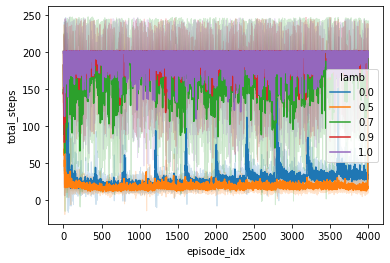

In [12]:
def script_plot_performance(in_df):
    plt_x = 'episode_idx'
    plt_y = 'total_steps'
    plt_hue = 'lamb'
    plt_ci = 'sd'
    plt_n_boot = 200
    
    # # 
    filters = {
        'lr': [0.1]
    }
    
    # ==
    # Copy and filter
    df = in_df.copy(deep=True)
    for k in filters:
        df = df[df[k].isin(filters[k])]
    
    # ==
    # Plot
    
    # Generate hue colors
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("tab10", n_hues) 
        
    sns.lineplot(x=plt_x, y=plt_y, 
                 hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette,
                 data=df)

script_plot_performance(Data_df)

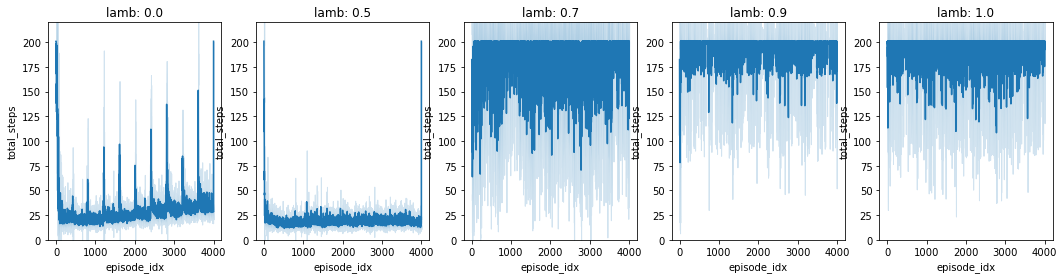

In [13]:
def script_plot_performance(in_df):
    plt_x = 'episode_idx'
    plt_y = 'total_steps'
    plt_hue = None
    plt_ci = 'sd'
    plt_n_boot = 200
    
    # # 
    filters = {
        'lr': [0.1]
    }
    
    # ==
    # Copy and filter
    df = in_df.copy(deep=True)
    for k in filters:
        df = df[df[k].isin(filters[k])]
    
    # ==
    # Plot
        
    subplt_list = sorted(list(set(Data_df['lamb'])))
    plt.figure(figsize=(18,4))
    
    for i, cur_attr in enumerate(subplt_list):
        cur_df = df[df['lamb'] == cur_attr]
        
        plt.subplot(1, len(subplt_list), i+1)
        
        sns.lineplot(x=plt_x, y=plt_y, 
                     hue=plt_hue,
                     ci=plt_ci, n_boot=plt_n_boot, 
                     data=cur_df)
        plt.ylim([0, 220])
        plt.title(f'lamb: {cur_attr}')

script_plot_performance(Data_df)

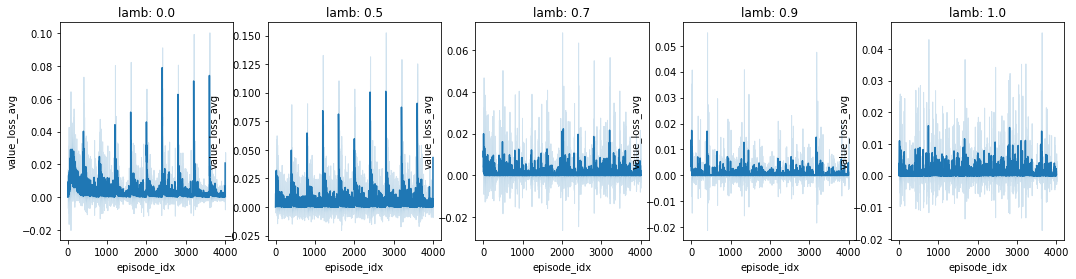

In [14]:
def script_plot_losses(in_df, y):
    plt_x = 'episode_idx'
    plt_y = y
    plt_hue = None
    plt_ci = 'sd'
    plt_n_boot = 200
    
    # # 
    filters = {
        'lr': [0.1]
    }
    
    # ==
    # Copy and filter
    df = in_df.copy(deep=True)
    for k in filters:
        df = df[df[k].isin(filters[k])]
    
    # ==
    # Plot
        
    subplt_list = sorted(list(set(Data_df['lamb'])))
    plt.figure(figsize=(18,4))
    
    for i, cur_attr in enumerate(subplt_list):
        cur_df = df[df['lamb'] == cur_attr]
        
        plt.subplot(1, len(subplt_list), i+1)
        
        sns.lineplot(x=plt_x, y=plt_y, 
                     hue=plt_hue,
                     ci=plt_ci, n_boot=plt_n_boot, 
                     data=cur_df)
        plt.title(f'lamb: {cur_attr}')

script_plot_losses(Data_df, y='value_loss_avg')

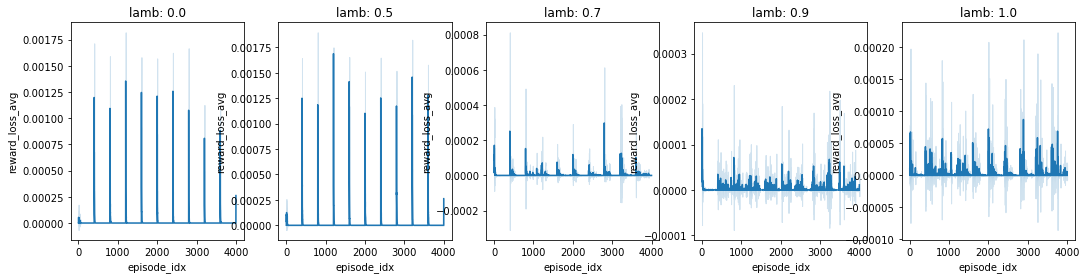

In [15]:
script_plot_losses(Data_df, y='reward_loss_avg')

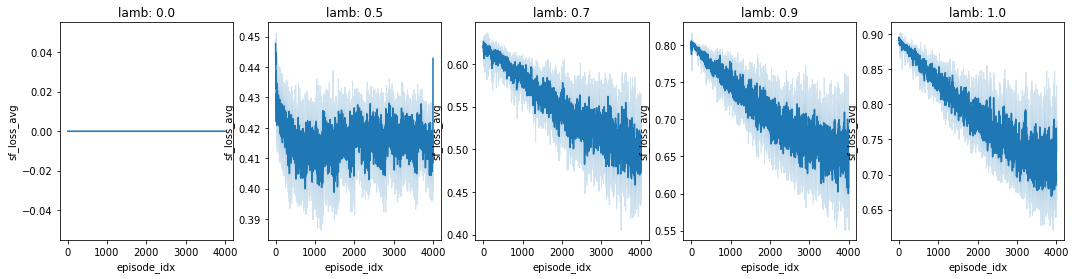

In [16]:
script_plot_losses(Data_df, y='sf_loss_avg')